In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
import random
import os
import glob

In [2]:
# Load the dataset
chunk_size = 100000  
chunks = pd.read_csv('./data/dataset18.csv', chunksize=chunk_size)

data = pd.concat(chunks, ignore_index=True)


In [3]:
data.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents label detailed-label
0,1.545337e+09,CddD2d1qU4UCgtFGV1,192.168.1.197,123,217.30.75.147,123,udp,-,0.002241,48,...,SF,-,-,0,Dd,1,76,1,76,- Benign -
1,1.545337e+09,CWsvajFlOE7fg2py4,192.168.1.197,123,94.124.107.190,123,udp,-,0.006726,48,...,SF,-,-,0,Dd,1,76,1,76,- Benign -
2,1.545337e+09,Cthriq2tzQhGjBK304,192.168.1.197,123,89.221.214.130,123,udp,-,0.003734,48,...,SF,-,-,0,Dd,1,76,1,76,- Benign -
3,1.545337e+09,CC2GtA46zw7L9veEI4,192.168.1.197,123,81.2.254.224,123,udp,-,0.004739,48,...,SF,-,-,0,Dd,1,76,1,76,- Benign -
4,1.545337e+09,CozNZa1gT9JUxCsqz2,192.168.1.197,123,81.2.248.189,123,udp,-,0.004739,48,...,SF,-,-,0,Dd,1,76,1,76,- Benign -


In [4]:
data.columns

Index(['ts', 'uid', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p',
       'proto', 'service', 'duration', 'orig_bytes', 'resp_bytes',
       'conn_state', 'local_orig', 'local_resp', 'missed_bytes', 'history',
       'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes',
       'tunnel_parents   label   detailed-label'],
      dtype='object')

In [5]:
data['tunnel_parents   label   detailed-label'].head(70)

0                                -   Benign   -
1                                -   Benign   -
2                                -   Benign   -
3                                -   Benign   -
4                                -   Benign   -
                        ...                    
65    -   Malicious   PartOfAHorizontalPortScan
66    -   Malicious   PartOfAHorizontalPortScan
67    -   Malicious   PartOfAHorizontalPortScan
68    -   Malicious   PartOfAHorizontalPortScan
69                        -   Malicious   Okiru
Name: tunnel_parents   label   detailed-label, Length: 70, dtype: object

In [6]:
data[['tunnel_parents', 'label', 'detailed_label']] = data['tunnel_parents   label   detailed-label'].str.split(r'\s+', expand=True)

# Drop the original combined column
data = data.drop('tunnel_parents   label   detailed-label', axis=1)

print(data[['tunnel_parents', 'label', 'detailed_label']].head())

  tunnel_parents   label detailed_label
0              -  Benign              -
1              -  Benign              -
2              -  Benign              -
3              -  Benign              -
4              -  Benign              -


### Data Cleaning
#### 1. Duplicate values

In [7]:
# Check for duplicate rows in the dataset
duplicate_rows = data[data.duplicated(keep=False)]
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")

# Preview some duplicate rows
duplicate_rows

Number of duplicate rows: 0


,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,label,detailed_label


In [8]:
data.shape

(54454591, 23)

In [9]:
# # Remove duplicates (keep the first occurrence)
# data = data.drop_duplicates(keep="first").reset_index(drop=True)
# print(f"Shape after removing duplicates: {data.shape}")

#### 2. Infinite values

In [10]:
# Checking for number of infinity values
numeric_cols = data.select_dtypes(include = np.number).columns
inf_count = np.isinf(data[numeric_cols]).sum()
print(inf_count[inf_count > 0])

Series([], dtype: int64)


#### 3. Missing values

In [11]:
# Count missing values per column
missing_counts = data.isna().sum()
print("Total missing values:", missing_counts.sum())

# Show only columns with missing values
missing_counts[missing_counts > 0].sort_values(ascending=False)

Total missing values: 0


Series([], dtype: int64)

### Data Preparation
#### 1. Feature selection/exctraction

In [12]:
# Dropping columns that has only one unique value
num_unique = data.nunique()
one_variable = num_unique[num_unique == 1]
not_one_variable = num_unique[num_unique > 1].index

dropped_cols = one_variable.index
data = data[not_one_variable]

print('Dropped columns:')
dropped_cols

Dropped columns:


Index(['local_orig', 'local_resp', 'tunnel_parents'], dtype='object')

#### 2. Data labeling

In [13]:
data['label'].value_counts()


label
Malicious    53073800
Benign        1380791
Name: count, dtype: int64

In [14]:
data['detailed_label'].value_counts()

detailed_label
PartOfAHorizontalPortScan    39459055
Okiru                        13609467
-                             1380791
C&C-HeartBeat                    5278
Name: count, dtype: int64

In [15]:
data.columns

Index(['ts', 'uid', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p',
       'proto', 'service', 'duration', 'orig_bytes', 'resp_bytes',
       'conn_state', 'missed_bytes', 'history', 'orig_pkts', 'orig_ip_bytes',
       'resp_pkts', 'resp_ip_bytes', 'label', 'detailed_label'],
      dtype='object')

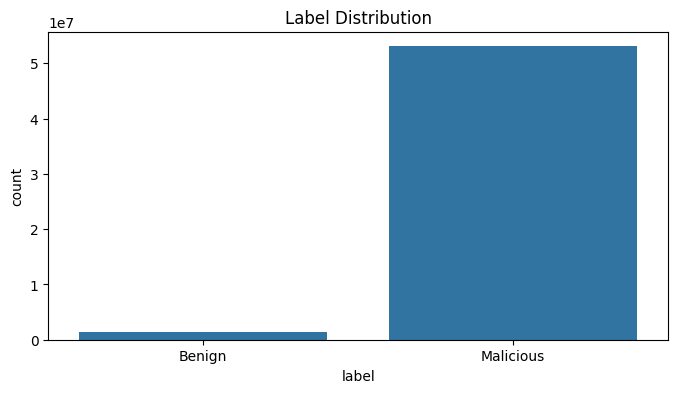

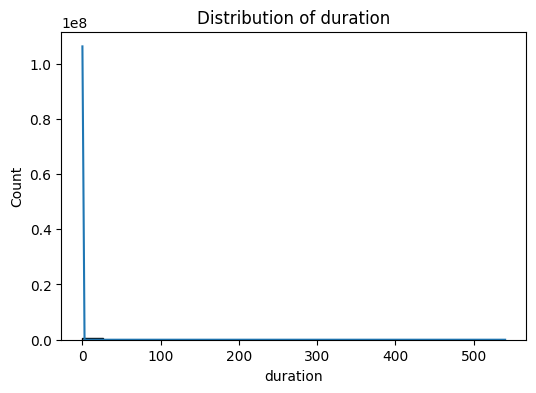

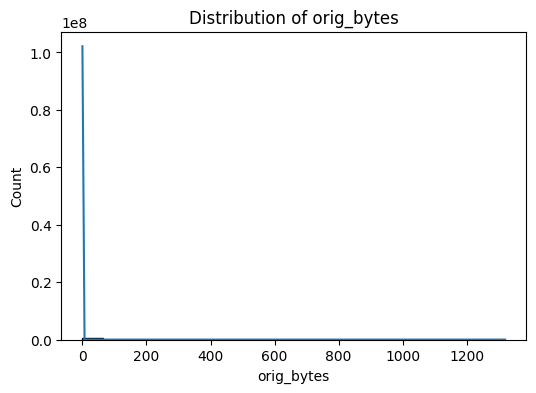

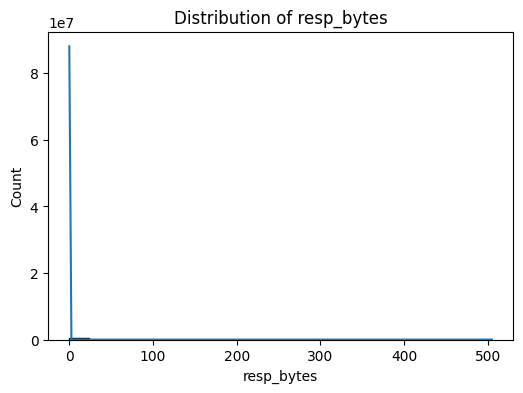

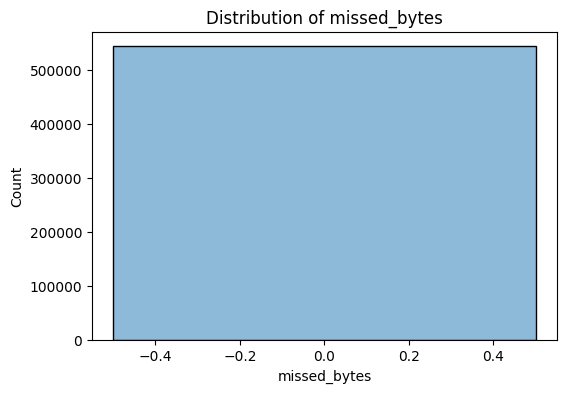

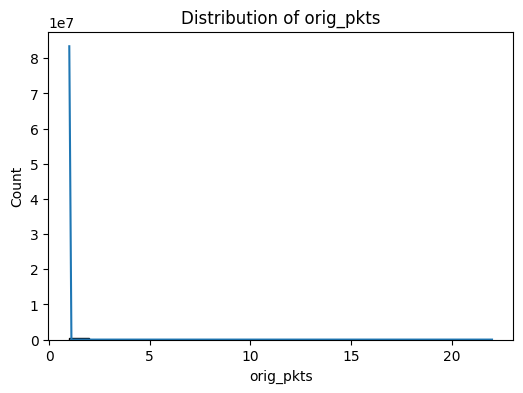

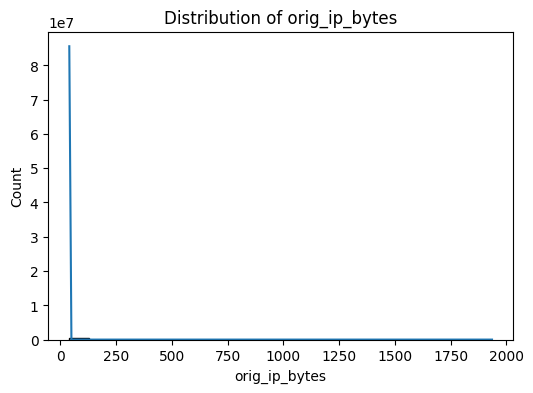

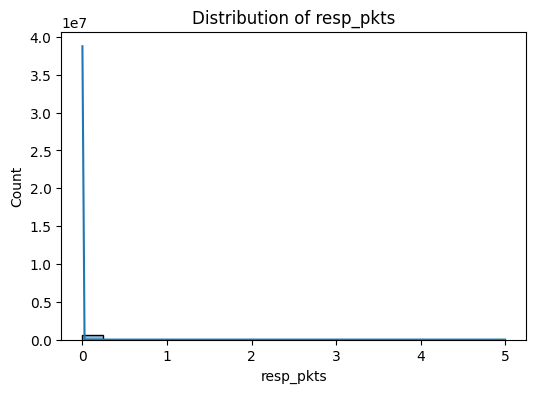

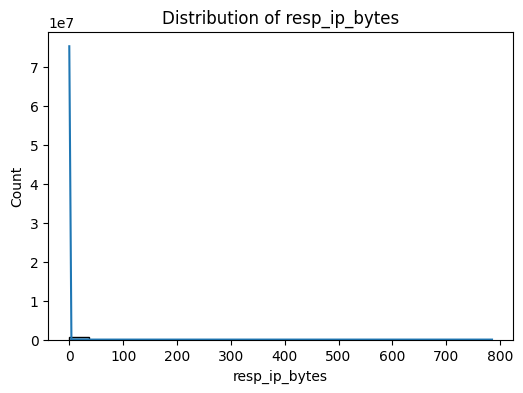

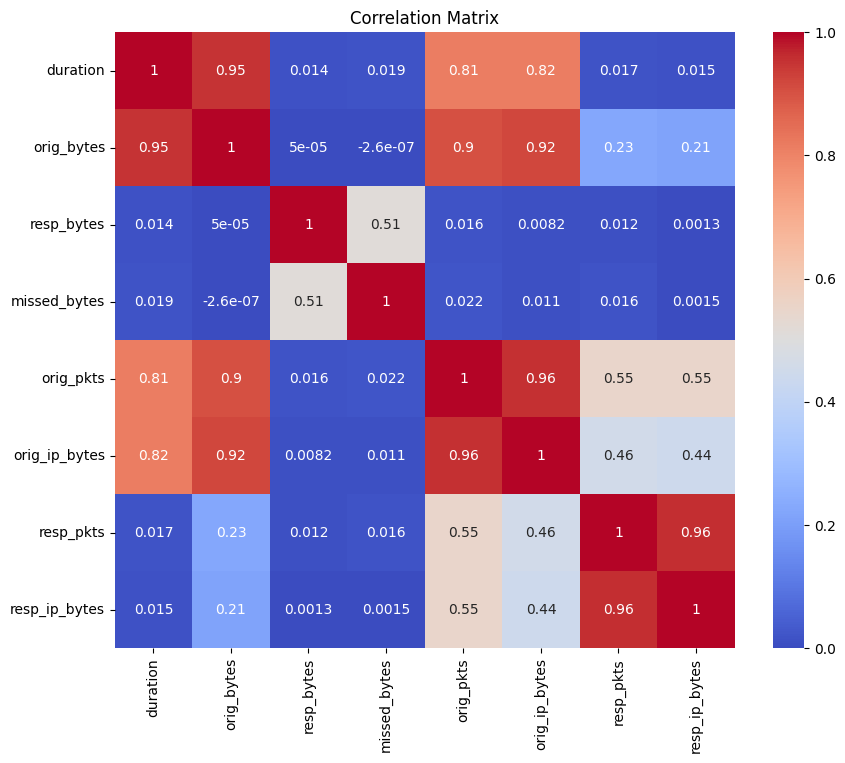

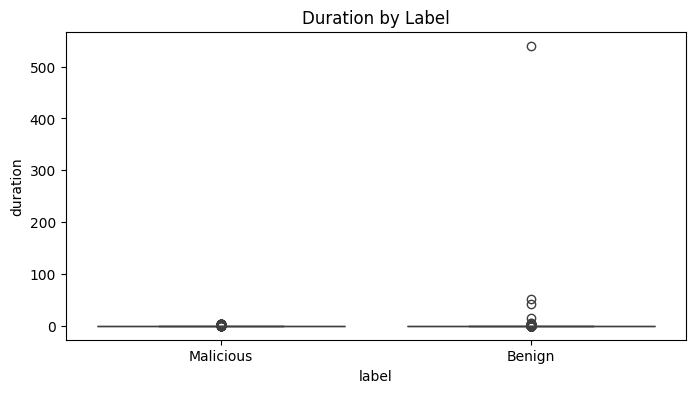

In [16]:
# Numerical features summary
numerical_cols = ['duration', 'orig_bytes', 'resp_bytes', 'missed_bytes', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes']
categorical_cols = ['proto', 'service', 'conn_state', 'history']

for col in numerical_cols:
    data[col] = data[col].replace('-', '0') 
    data[col] = pd.to_numeric(data[col], errors='coerce')

data[numerical_cols] = data[numerical_cols].fillna(0)

# Visualizations
# Class distribution
plt.figure(figsize=(8, 4))
sns.countplot(x='label', data=data)
plt.title('Label Distribution')
plt.show()

# Numerical distributions (sample if too large)
data_sample = data.sample(frac=0.01)  # 1% sample for quick viz
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(data_sample[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

# Correlation heatmap (numerical only)
corr = data[numerical_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Boxplot for outliers (e.g., duration by label)
plt.figure(figsize=(8, 4))
sns.boxplot(x='label', y='duration', data=data_sample)
plt.title('Duration by Label')
plt.show()